# Предсказание давления на приёме по показаниям датчиков

Задача: по показаниями датчиков при добычи нефти со скважины «Зимнее» предсказать давление на приёме.

 - Провести EDA;
 - Выбрать модель по gridsearch; метрика качества — MSE;
 - Код сопроводить комментариями и выводами по каждому этапу. 

### Импорт необходимых библиотек, модулей и моделей

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
import time

### Загрузка данных

In [2]:
data = pd.read_excel('TR_nef.xlsx',sheet_name='Main',skiprows=[0,1,3,4])

### Структура данных датасета data
 - размеры
 - проверка пропущенных значений 
 - типы признаков

In [3]:
print('Shape : ' + str(data.shape))
print('Isnull : ' +str(data.isnull().values.any()))
print(data.info())
data.head()

Shape : (9376, 113)
Isnull : True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9376 entries, 0 to 9375
Columns: 113 entries, Дата to ГП - Общий прирост Qн
dtypes: float64(75), int64(18), object(20)
memory usage: 8.1+ MB
None


,Дата,Скважина,Пласт МЭР,Куст,Цех,Тип скважины,Диаметр экспл.колонны,Диаметр НКТ,Диаметр штуцера,Глубина верхних дыр перфорации,...,ГП - Забойное давление,ГП(ИДН) Дебит жидкости,ГП(ИДН) Дебит жидкости скорр-ый,ГП(ИДН) Дебит нефти,ГП(ИДН) Прирост дефита нефти,ГП(ГРП) Дебит жидкости,ГП(ГРП) Дебит жидкости скорр-ый,ГП(ГРП) Дебит нефти,ГП(ГРП) Прирост дефита нефти,ГП - Общий прирост Qн
0,3.2017,101,АС10,19,ЦДНГ-4,Наклонно-направленно,146.8,73.0,0,2469.0,...,29.2,12.283600,12.283600,3.526622,0.081422,65.162366,65.162366,18.708115,15.181494,15.262915
1,2.2017,101,АС10,19,ЦДНГ-4,Наклонно-направленно,146.8,73.0,0,2469.0,...,29.4,11.511567,11.511567,3.304971,0.146871,62.257008,62.257008,17.873987,14.569016,14.715887
2,1.2017,101,АС10,19,ЦДНГ-4,Наклонно-направленно,146.8,73.0,0,2469.0,...,29.6,14.463897,14.463897,6.417631,0.205831,72.397661,72.397661,32.122842,25.705211,25.911042
3,12.2016,101,АС10,19,ЦДНГ-4,Наклонно-направленно,146.8,73.0,0,2469.0,...,29.3,15.499539,15.499539,8.090759,0.260759,75.768493,75.768493,39.551153,31.460394,31.721153
4,11.2016,101,АС10,19,ЦДНГ-4,Наклонно-направленно,146.8,73.0,0,2469.0,...,29.7,14.381373,14.381373,7.882431,0.209031,73.938948,73.938948,40.525937,32.643507,32.852537


 - Как видно, в данных присутсвуют пропуски. Кроме числовых типов, имеются 20 объектов. Поэтому базовым этапом в предобработке датасета будет кодирование категориальных признаков, а так же удаление пропущенных значений. Также нужно провести проверку на количество уникальных значений каждого признака, т.к. признаки с одним только уникальным значением не будут способствовать улучшению модели.

### Выделение целевого признака 'Давление на приеме'

In [4]:
data = shuffle(data, random_state=123)
y = data['Давление на приеме']
print(str(y.shape))

(9376,)


### Поиск объектных признаков, в которых только одно уникальное значение

In [5]:
object_cols = data.columns[data.dtypes == object]
exclude_obj_cols=[]
for column in object_cols:
    if data[column].nunique()==1:
        exclude_obj_cols.append(column)
exclude_obj_cols

['Пласт МЭР',
 'Цех',
 'Нерентабельная',
 'Неустановившийся режим',
 'Тип дополнительного оборудования',
 'ДНС',
 'КНС']

 - Как видно, имеются 7 таких признаков. Исключим их:

In [6]:
data = data.drop(exclude_obj_cols, axis=1)
print(str(data.shape))

(9376, 106)


### Поиск числовых признаков, в которых только одно уникальное значение

In [7]:
num_cols = data._get_numeric_data().columns
exclude_num_cols=[]
for column in num_cols:
    if data[column].nunique()==1:
        exclude_num_cols.append(column)
exclude_num_cols

['Коэффициент сепарации',
 'Давление наcыщения',
 'Температура пласта',
 'Вязкость нефти в пластовых условиях',
 'Вязкость воды в пластовых условиях',
 'объемный коэффициент',
 'Плотность нефти',
 'Плотность воды',
 'Число качаний ШГН',
 'Длина хода плунжера ШГН',
 'Диаметр плунжера',
 'ШГН - Теоретический дебит',
 'Коэффициент подачи насоса',
 'КН закрепленный',
 'Время в работе',
 'Время в накоплении']

 - Как видно, имеются 16 таких признаков. Исключим их:

In [8]:
data = data.drop(exclude_num_cols, axis=1)
print(str(data.shape))

(9376, 90)


### Поиск признаков с пропущенными значениями

In [9]:
null_columns=data.columns[data.isna().any()]
data[null_columns].isna().sum()

Куст                       191
Тип скважины              5172
Дата ГРП                  2391
Фирма ГРП                 9376
Причина простоя           9269
Примечание                9376
Дата запуска после КРС     122
Мероприятия               9361
Назначение по проекту        6
Тип газосепаратора        9376
Марка ПЭД                 2648
Станок-качалка            9376
dtype: int64

 - Как видно, имеются 12 таких признаков. Исключим их:

In [10]:
data = data.drop(null_columns, axis=1)
data_num = data[data._get_numeric_data().columns]
print(str(data.shape))

(9376, 78)


 - Для корректной работы модели необходимо преобразовать категориальные признаки. Закодируем категориальные переменные с помощью функции get_dummies, объединим все в один датафрейм и удалим оригинальные столбцы категориальных переменных:

In [11]:
categ_cols = data.columns[data.dtypes == object]
print(categ_cols)

print(data.shape, 'before one hot encoding')
for column in categ_cols:
    data = pd.concat([data, pd.get_dummies(data[column])], axis=1)
data.drop(categ_cols, axis=1, inplace=True)
print(data.shape, 'after one hot encoding') 

Index(['Скважина', 'Способ эксплуатации', 'Тип насоса',
       'Состояние на конец месяца', 'Фонтан через насос', 'Группа фонда',
       'Тип ГЗУ'],
      dtype='object')
(9376, 78) before one hot encoding
(9376, 478) after one hot encoding


 - Нашлось 7 категориальных признаков. После кодировки из 78 признаков стало 478.

### Разделение данных

In [12]:
X_target = data[data['Давление на приеме']==0]
X = data[data['Давление на приеме']>0]

X_target = X_target.drop('Давление на приеме', axis=1)
X = X.drop('Давление на приеме', axis=1)

y = y[y>0]

print('Размер исходного датасета data: ' + str(data.shape))
print('Размер целевой выборки X_target: ' + str(X_target.shape))
print('Размер обучающей выборки X: ' + str(X.shape))
print('Размер известных ответов y: ' +  str(y.shape))


Размер исходного датасета data: (9376, 478)
Размер целевой выборки X_target: (3557, 477)
Размер обучающей выборки X: (5819, 477)
Размер известных ответов y: (5819,)


 - X_target - данные, чьи ответы нужно предсказать
 - X - обучающая выборка
 - y - ответы для обучающей выборки

### Корреляции в данных

 - оценим уровень линейной зависимости между признаками и целевой переменной корреляцией Пирсона:

Index(['Забойное давление', 'Замерное забойное давление'], dtype='object')

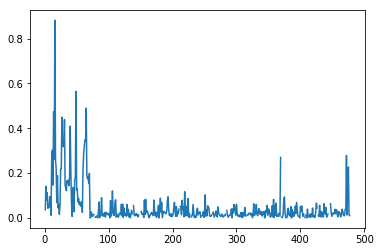

In [13]:
plt.plot(range(1,X.shape[1]+1),np.abs(X.corrwith(y)))
X.columns[np.abs(X.corrwith(y))>=0.5]

 - Признак 'Забойное давление' хорошо коррелирует с целевым признаком 'Давление на приеме'. Корреляции вещественных признаков (до 70) превышают корреляции категориальных признаков. Они более информативны. Имеет смысл также обучить модель только на этих признаках. 
 - Посмотрим корреляции между самими вещественными признаками:

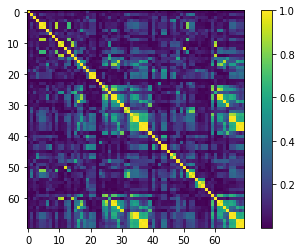

In [14]:
xcor = np.array(abs(X.corr()))
xcor = xcor[0:70,0:70]
plt.imshow(xcor);
plt.colorbar();

 - как видно, между числовыми признаками присутствуют сильные корреляции.

### Расределение значений целевого признака y

 - Построим распредление значений целевого признака y и посмотрим, нет ли сильно отличающихся значений 

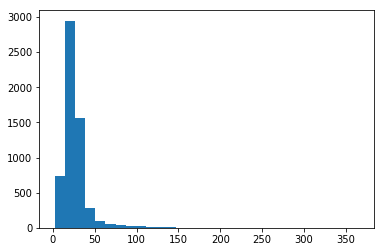

In [15]:
plt.hist(y,bins=30);

 - как видно из гистограммы, распределение нормальное с одной модой без каких либо резких выбросов, поэтому можно оставить все объекты

### Масштаб признаков

 - Оценим насколько отличаются значения признаков

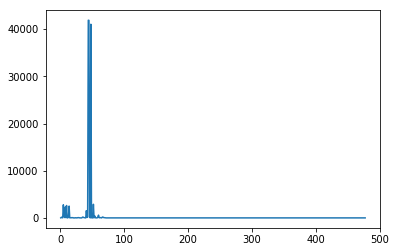

In [16]:
plt.plot(range(1,X.shape[1]+1),X.mean(axis=0))

 - некоторые признаки достигают разницы до 4 порядков. Отмасштабируем выборку X и запишем в новую перменную Xscaled:

In [17]:
Xscaled = scale(X)
X_target_scaled = scale(X_target)

### Построение моделей

 - Расмотрим модели Случайного леса RandomForestRegressor и градиентных бустингов XGBRegressor и LGBMRegressor
 - Поиск параметров будем проводить по GridSearchCV с параметрами 'n_estimators','max_features' и 'max_depth' c кросс-валидацией на 3 фолда
 - Определение точности по MSE

#### RandomForestRegressor

In [18]:
t = time.time()
params_random_forest = {'max_features':[32,64,128,256,360],'n_estimators' : [80,100],'max_depth' : [10,30,50,80]}
random_forest = GridSearchCV(RandomForestRegressor(), param_grid=params_random_forest, cv=3,scoring='neg_mean_squared_error')
random_forest.fit(Xscaled, y)
random_forest.best_score_, random_forest.best_params_
elapsed = time.time() - t
print(random_forest.best_score_, random_forest.best_params_)
print(elapsed)

-17.639771355043827 {'max_depth': 80, 'max_features': 360, 'n_estimators': 100}
680.5472750663757


 - Лучшее среднее значение MSE по 3 фолдам достигается при {'max_depth': 80, 'max_features': 360, 'n_estimators': 100}
 и равна 17.63. При этом счет занял 680 сек. Попробуем использовать модель градиентного бустинга XGBRegressor:

#### XGBRegressor

In [19]:
t = time.time()
params_xgb = {'n_estimators' : [40,60,80,100],'max_depth' : [10,30,50,80]}
xgb = GridSearchCV(XGBRegressor(), param_grid=params_xgb, cv=3,scoring='neg_mean_squared_error')
xgb.fit(Xscaled, y)
elapsed = time.time() - t
print(xgb.best_score_, xgb.best_params_)
print(elapsed)

-21.67993708872162 {'max_depth': 10, 'n_estimators': 40}
1167.014966726303


- Точность ухудшилась и стала равной 21.67 при параметрах {'max_depth': 10, 'n_estimators': 40}. Время счета 1167 сек. Попробуем использовать модель градиентного бустинга LGBMRegressor:

#### LGBMRegressor

In [20]:
t = time.time()
params_lgb = {'n_estimators' : [40,60,80,100],'max_depth' : [10,30,50,80]}
lgb = GridSearchCV(LGBMRegressor(), param_grid=params_lgb, cv=3,scoring='neg_mean_squared_error')
lgb.fit(Xscaled, y)
elapsed = time.time() - t
print(lgb.best_score_, lgb.best_params_)
print(elapsed)

-18.991771072673146 {'max_depth': 30, 'n_estimators': 100}
65.48457145690918


- Точность 18.99 при параметрах {'max_depth': 30, 'n_estimators': 100}. Время счета 65 сек. Очень быстро и средняя точность между RandomForestRegressor и XGBRegressor.

### LGBMRegressor на числовых признаках

 - Теперь попробуем обучить модель только на тех данных, которые изначально были числовыми так как их корреляции с целевым признаком y превышали фон корреляции кодированных категориальных признаков. Сначала разделим данные и отмасштабируем:

In [21]:
X_target_num = data_num[data_num['Давление на приеме']==0]
X_num = data_num[data_num['Давление на приеме']>0]

X_target_num = X_target_num.drop('Давление на приеме', axis=1)
X_num = X_num.drop('Давление на приеме', axis=1)

print('Размер исходного датасета data_num: ' + str(data_num.shape))
print('Размер целевой выборки X_target_num: ' + str(X_target_num.shape))
print('Размер обучающей выборки X_num: ' + str(X_num.shape))

Размер исходного датасета data_num: (9376, 71)
Размер целевой выборки X_target_num: (3557, 70)
Размер обучающей выборки X_num: (5819, 70)


In [22]:
Xscaled_num = scale(X_num)
Xscaled_target_num = scale(X_target_num)

In [25]:
t = time.time()
params_lgb = {'n_estimators' : [40,60,80,100],'max_depth' : [10,30,50,80]}
lgb_num = GridSearchCV(LGBMRegressor(), param_grid=params_lgb, cv=3,scoring='neg_mean_squared_error')
lgb_num.fit(Xscaled_num, y)
elapsed = time.time() - t
print(lgb_num.best_score_, lgb_num.best_params_)
print(elapsed)

-18.88152106874313 {'max_depth': 30, 'n_estimators': 100}
46.51195693016052


- Точность 18.88 практически не изменилась по сравнению с моделью с закодированными признаками! Параметры - {'max_depth': 30, 'n_estimators': 100}. Время счета 46 сек.

### SGDRegressor

 - Напоследок рассмотрим модель SGDRegressor:

In [47]:
t = time.time()
parameters_grid = {'loss' : ['huber', 'epsilon_insensitive', 'squared_loss'],'max_iter' : [20,50,60,70],'penalty' : ['l1', 'l2', 'none']}
SGDReg = GridSearchCV(SGDRegressor(), parameters_grid, scoring = 'neg_mean_squared_error', cv = 10)
SGDReg.fit(Xscaled_num, y)
elapsed = time.time() - t
print(SGDReg.best_score_, SGDReg.best_params_)
print(elapsed)

-21.02952505973797 {'loss': 'squared_loss', 'max_iter': 60, 'penalty': 'l1'}
74.07139301300049


- Точность 21 ненамного хуже остальных. Параметры - {'loss': 'squared_loss', 'max_iter': 60, 'penalty': 'l1'}. Время счета 74 сек.

# Предсказание

 - Спрогнозируем ответы по каждой построенной модели:

In [54]:
prediction_random_forest = random_forest.predict(X_target_scaled)
prediction_xgb = xgb.predict(X_target_scaled)
prediction_lgb = lgb.predict(X_target_scaled)
prediction_lgb_num = lgb_num.predict(Xscaled_target_num)
prediction_SGDReg = SGDReg.predict(Xscaled_target_num)

 - Сформируем общий датафрейм из предсказаний и посмотрим на значения:

In [60]:
prediction_all = pd.DataFrame([prediction_random_forest,prediction_xgb,prediction_lgb,prediction_lgb_num,prediction_SGDReg])

In [64]:
prediction_all.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556
0,30.390000,21.583000,28.990000,26.010000,29.570000,12.050000,18.540000,16.640000,30.370000,25.130000,...,21.650000,28.670000,31.620000,29.990000,30.000000,28.880000,26.640000,28.600000,13.290000,12.430000
1,29.878479,16.303307,28.321030,25.487345,30.055595,11.821149,18.408491,16.268082,31.995613,25.868069,...,23.680256,28.894335,32.130447,28.565775,30.060711,29.516647,27.499680,29.786083,12.607594,12.320120
2,26.138018,19.521858,29.593703,25.739660,29.135455,5.076692,18.334518,15.976032,33.504898,24.913450,...,22.837236,29.870920,34.217546,30.162718,30.914307,29.315318,27.853402,28.667768,8.873690,8.860042
3,30.636162,19.556627,29.296444,26.317728,28.531912,7.321590,18.544332,16.558999,33.550164,24.951574,...,23.429979,28.587206,34.835521,30.643157,31.224525,28.621925,27.514395,28.427475,11.780263,10.908864
4,24.410384,24.791331,25.297829,22.080123,21.034020,29.670200,9.276222,6.647822,24.615736,17.489402,...,17.802453,23.468587,26.550859,18.601049,29.681768,24.465785,25.333034,23.691196,12.596368,13.367353


 - В целом неплохо: первые 4 модели примерно близки. 
 - На их фоне выделяется последняя модель SGDRegressor. 
 - Наложим их графики друг на друга чтобы убедиться в этом: 

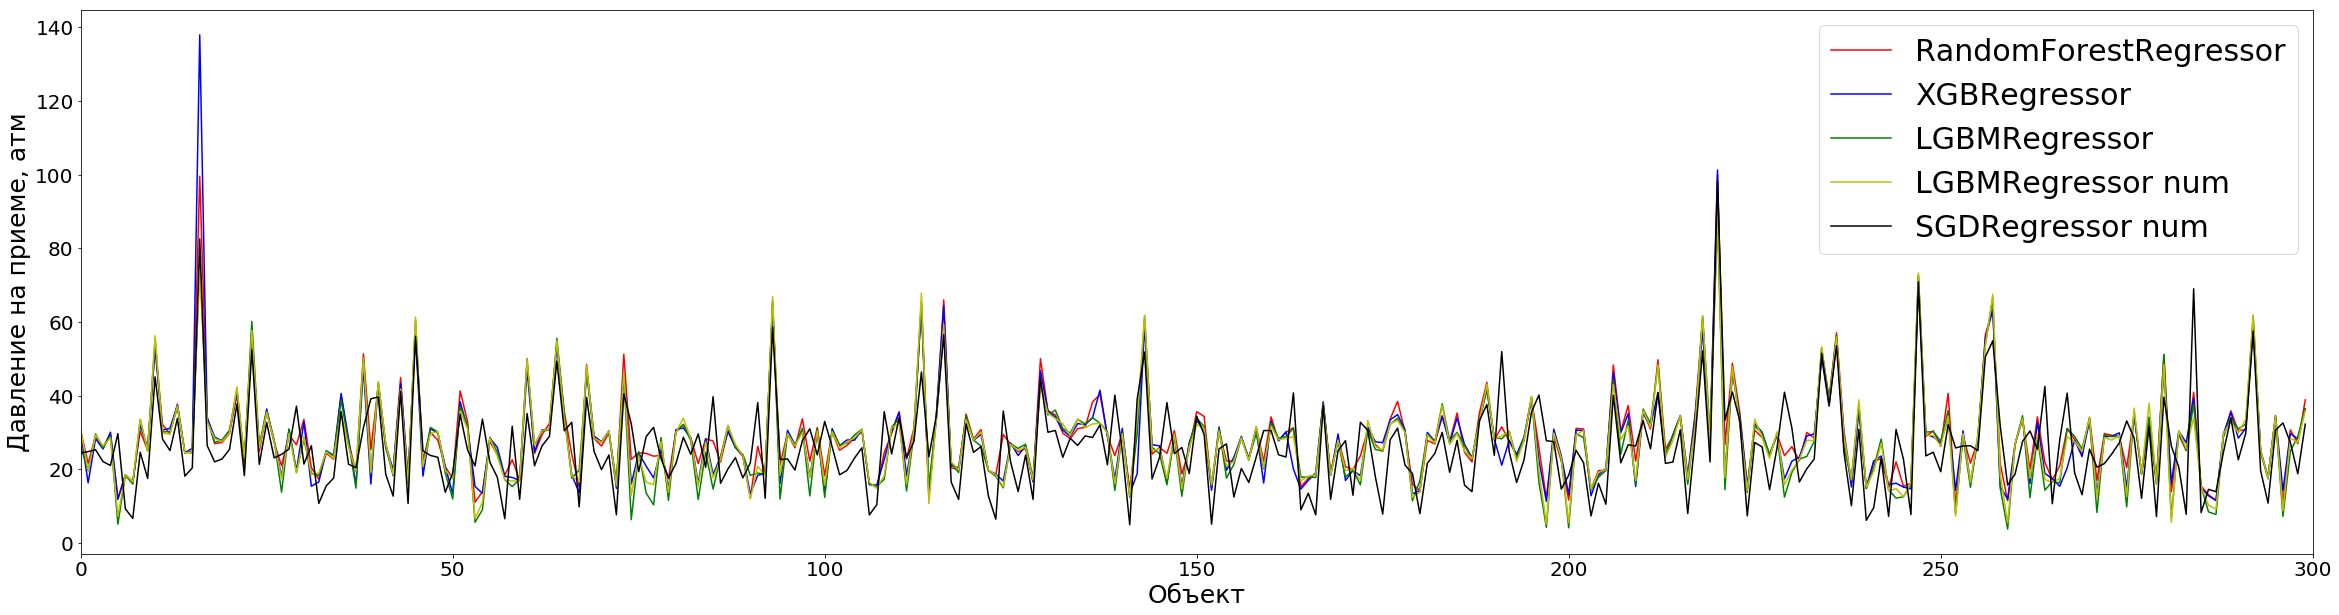

In [139]:
plt.figure(figsize=(40,10));
plt.plot(prediction_random_forest[0:300],'r');
plt.plot(prediction_xgb[0:300],'b');
plt.plot(prediction_lgb[0:300],'g');
plt.plot(prediction_lgb_num[0:300],'y');
plt.plot(prediction_SGDReg[0:300],'k');
plt.xlim([0,300]);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.xlabel('Объект',fontsize=25);
plt.ylabel('Давление на приеме, атм',fontsize=25);
plt.legend(['RandomForestRegressor','XGBRegressor','LGBMRegressor','LGBMRegressor num','SGDRegressor num'],prop={'size': 30});

 - Рассчитаем коэффициенты корреляции между предсказаниями, исключив SGDRegressor

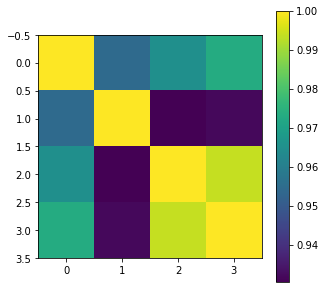

In [171]:
plt.figure(figsize=(5,5));
pred_xcor = np.array(abs(prediction_all.drop(4,axis=0).T.corr()))
plt.imshow(pred_xcor);
plt.colorbar();

 - Между предсказаниями достаточно высокий коэффициент корреляции. 
 - Самый низкий коэффициент связан с XGBRegressor, у которого самая худшая точность среди остальных моделей. 
 - Посмотрим на распределения. 
 - Добавим кроме самих предсказаний по 'RandomForestRegressor','XGBRegressor','LGBMRegressor','LGBMRegressor num' еще и средний между ними:

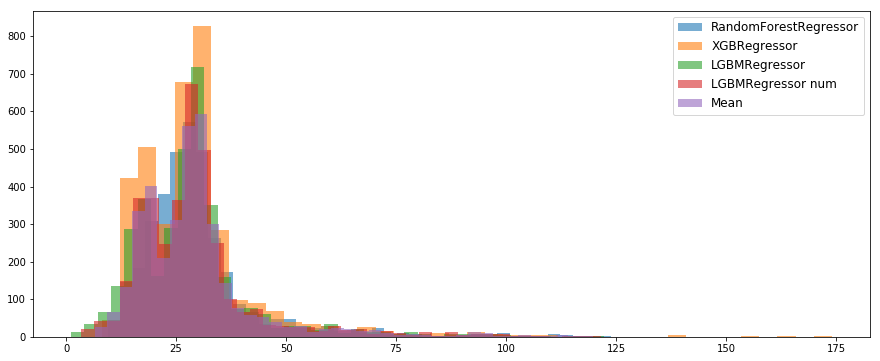

In [201]:
plt.figure(figsize=(15,6));
plt.hist(prediction_random_forest,alpha = 0.6,bins=40);
plt.hist(prediction_xgb,alpha = 0.6,bins=40);
plt.hist(prediction_lgb,alpha = 0.6,bins=40);
plt.hist(prediction_lgb_num,alpha = 0.6,bins=40);

prediction_mean = np.array(abs(prediction_all.drop(4,axis=0).mean()));
plt.hist(prediction_mean,alpha = 0.6,bins=40);

plt.legend(['RandomForestRegressor','XGBRegressor','LGBMRegressor','LGBMRegressor num','Mean'],prop={'size': 12});

 - Гистограммы в целом имеют похожие распределения.
 - Результатом будет среднее по 'RandomForestRegressor','XGBRegressor','LGBMRegressor','LGBMRegressor num' предсказание.

## Результат

 - Отсортируем значения по номеру строки и запишем в текстовый файл results.txt в формате: номер строки в файле TR_nef.xlsx , значение давления на приеме 

In [277]:
indx = np.sort(data.index[data['Давление на приеме']==0].values)
prediction_mean_sorted = np.array(prediction_mean)
prediction_mean_sorted = prediction_mean_sorted[np.argsort(data.index[data['Давление на приеме']==0].values)]
with open('results.txt','w') as file_obj:
    for i in range(prediction_mean_sorted.shape[0]):
        file_obj.writelines(str(indx[i]+6) + ' ' + str(prediction_mean_sorted [i]) + '\n')